<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/paddlepaddle/paddleocr/Train_and_Debug_Your_OCR_Models_with_PaddleOCR_and_W&B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{paddleocr} -->

<img src="https://raw.githubusercontent.com/PaddlePaddle/PaddleOCR/release/2.5/doc/PaddleOCR_log.png">

<!--- @wandbcode{paddleocr} -->

<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />

# Train and Debug Your OCR Models using PaddleOCR and Weights & Biases 🪄🐝

This notebook talks about how you can use W&B with PaddleOCR to track training metrics and log model checkpoints for all your OCR needs!

To use the W&B logger with the PaddleOCR training script just add the following at the bottom of your `config.yml` file.

```
wandb:
    project: CoolOCR
    entity: my_team
    name: MyOCRModel
```

To log the metrics and checkpoints to W&B during training, the wandb client now has a direct integration into PaddleOCR. Using wandb for logging automatically adds all the metrics to your W&B dashboard, saves the models at every evaluation step, tags the best model and adds appropriate metadata for the saved model. An example dashboard is available [here](https://wandb.ai/manan-goel/text_detection).

## Setup 🖥

We begin by cloning the PaddleOCR library and installing the the package.

In [ ]:

!git clone https://github.com/PaddlePaddle/PaddleOCR
!python -m pip install paddlepaddle-gpu==2.3.2.post112 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html
!pip install pyclipper attrdict opencv-python shapely scikit-image imgaug -qqq
!cd PaddleOCR && pip install -e .

Now we'll install and log into W&B.

In [ ]:
!pip install wandb -qU

In [ ]:

import wandb
wandb.login()

In [ ]:
%cd PaddleOCR

## Training 🏋️‍♀️

PaddleOCR comes with a huge array of pre-implemented models involved in the OCR pipeline. For this tutorial we will be looking at the text detection models.

### Downloading Training and Validation Data 💾

We will use the ICDAR2015 dataset available [here](https://rrc.cvc.uab.es/?ch=4&com=downloads). The data has been logged as W&B artifacts for ease of use.

In [ ]:
api = wandb.Api()
artifact = api.artifact("manan-goel/icdar2015/icdar2015-dataset:latest")
artifact.download(root="./train_data/icdar2015")

### Downloading pretrained weights📈

In [ ]:
!wget -P ./pretrain_models/ https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/MobileNetV3_large_x0_5_pretrained.pdparams

### Setup the config.yml file to use W&B🛠

In [ ]:
import yaml

with open("configs/det/det_mv3_db.yml", "r") as f:
    config = yaml.safe_load(f)
config.update({
    'wandb': {
        'project': 'text_detection'
    }
})
config['Global'].update({
    'epoch_num': 5,
    'eval_batch_step': [0, 50],
    'calc_metric_during_train': True
})

with open("configs/det/det_mv3_db.yml", "w") as f:
    yaml.safe_dump(config, f)

### Train your Model 🏋️‍♀️

The following command will finetune the pretrained MobileNetV3 on the ICDAR2015 dataset while logging all training and validation metrics to a W&B dashboard.

In [ ]:
!python3 tools/train.py -c configs/det/det_mv3_db.yml  \
         -o Global.pretrained_model=./pretrain_models/MobileNetV3_large_x0_5_pretrained

The [dashboard](https://wandb.ai/manan-goel/text_detection) would look something like this

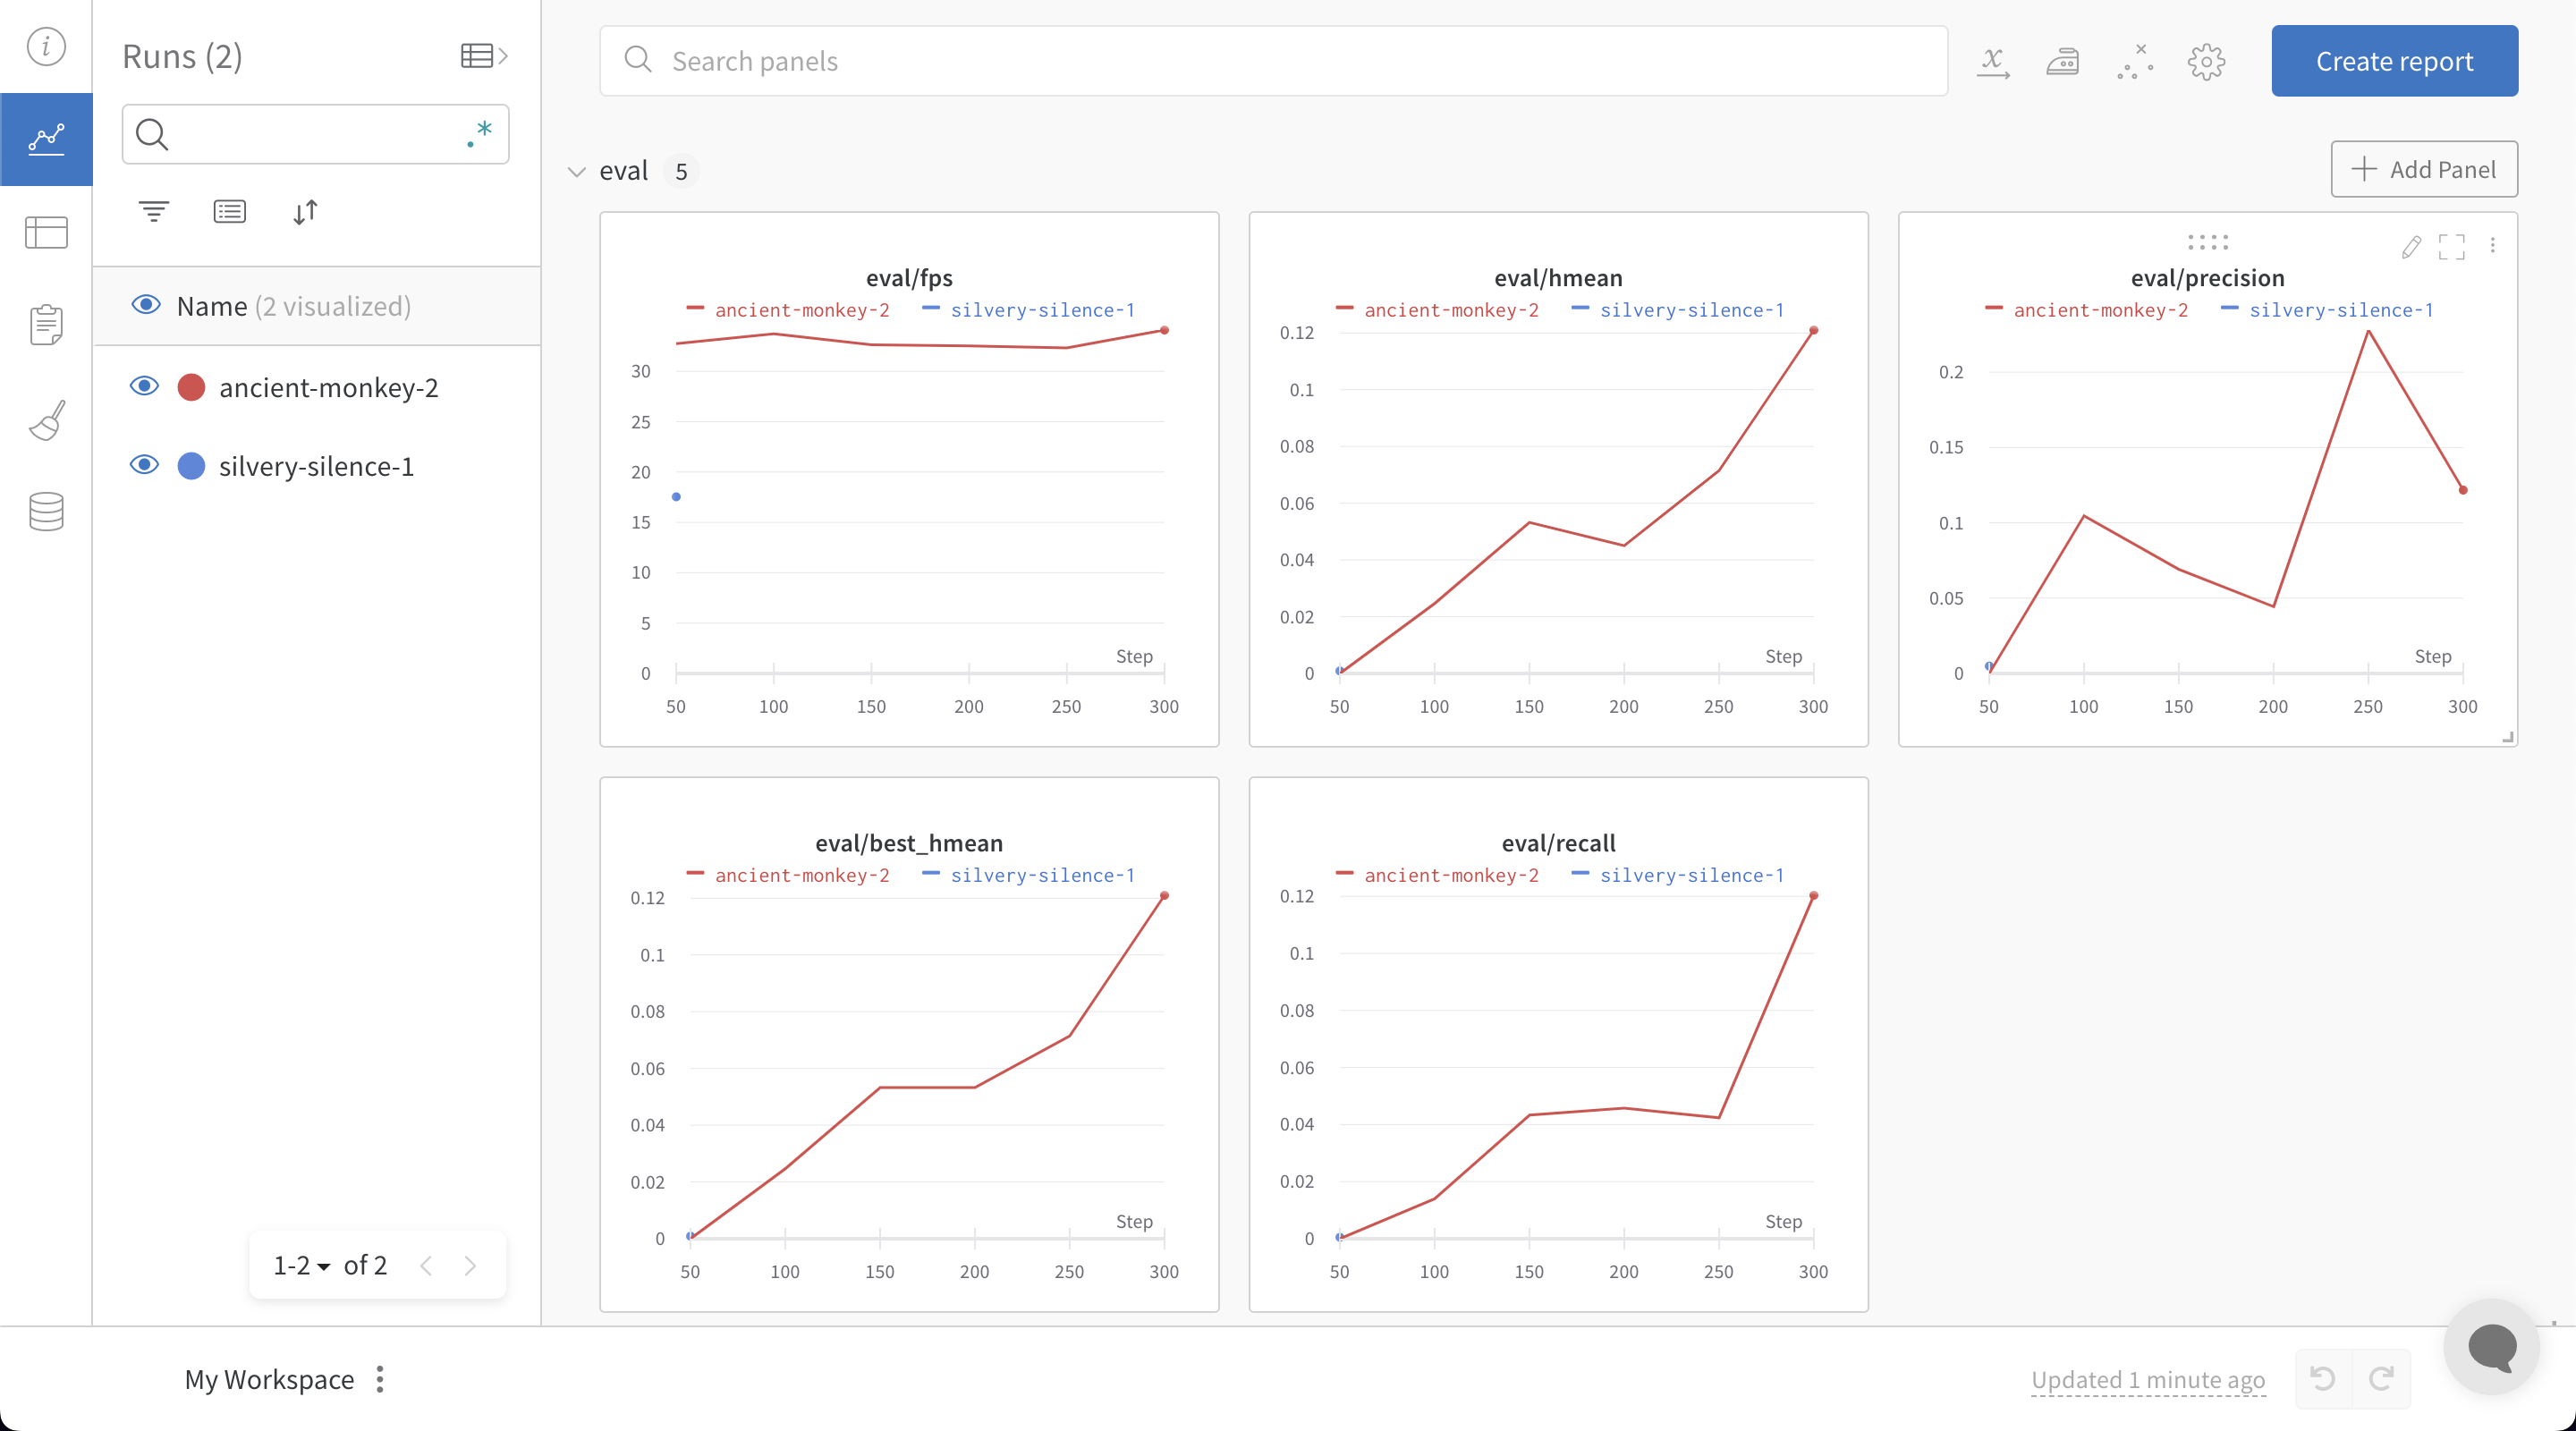

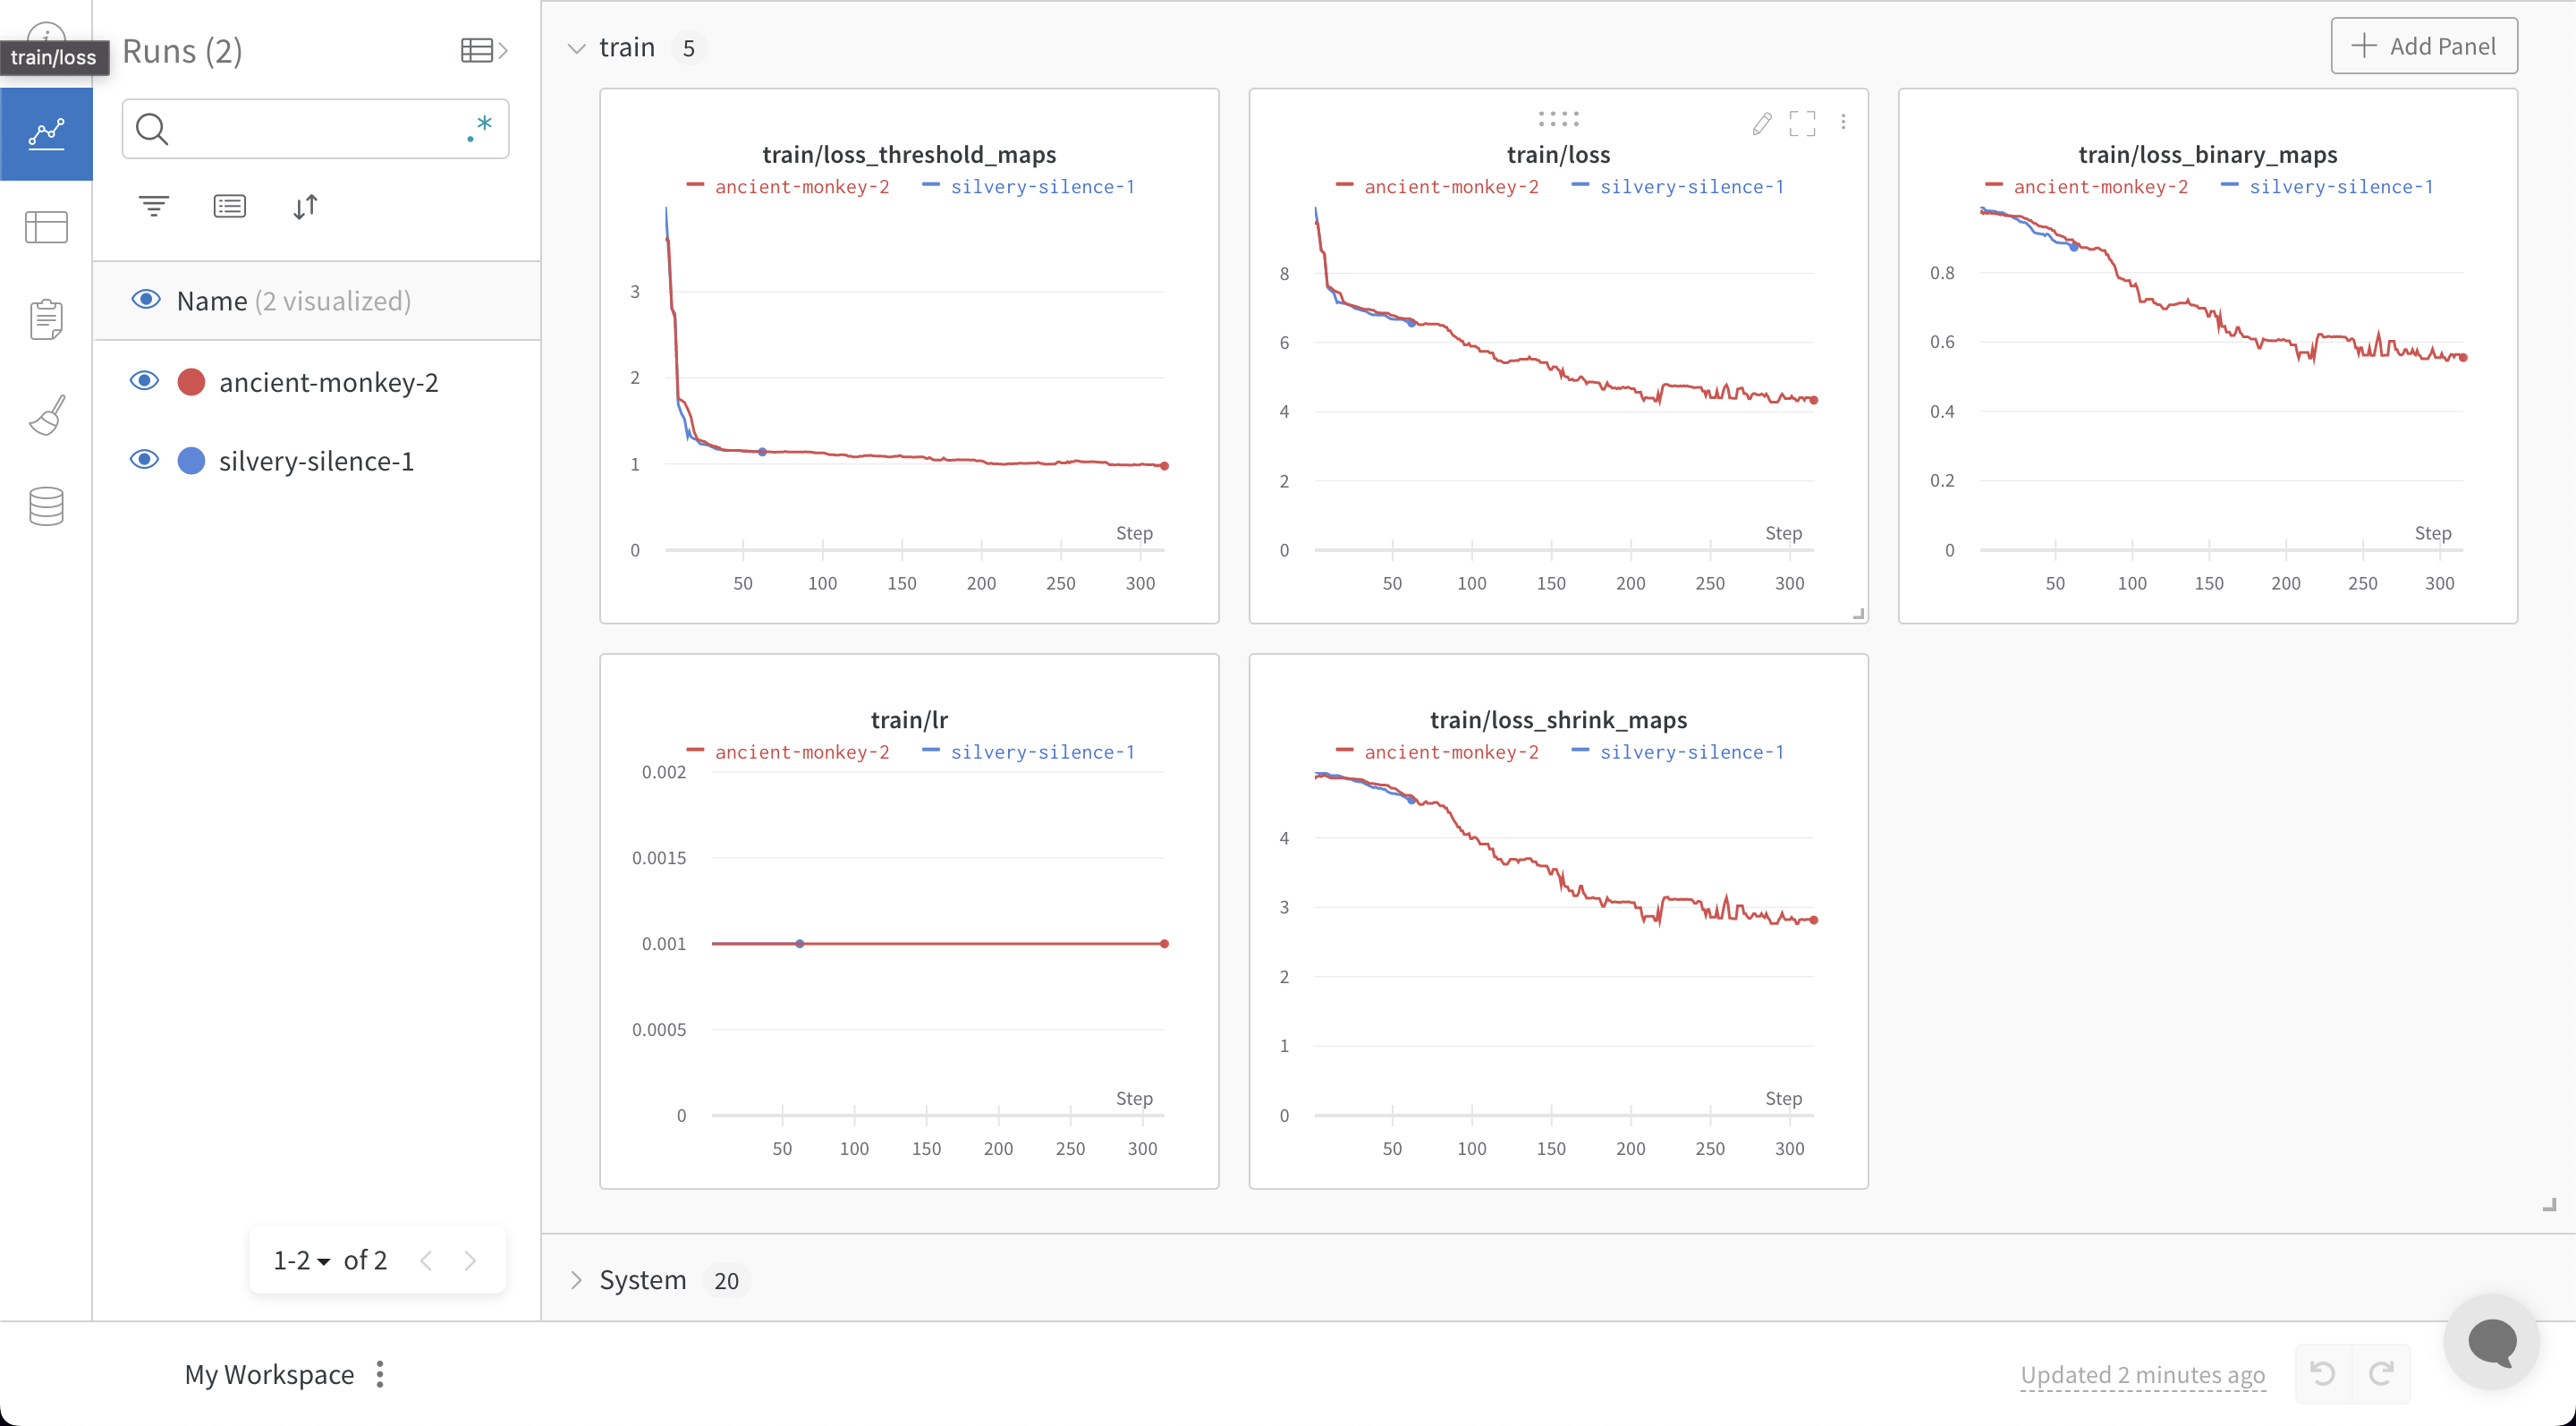

The checkpoints at the end of every epoch and evaluation step are also logged to W&B with appropriate metadata!

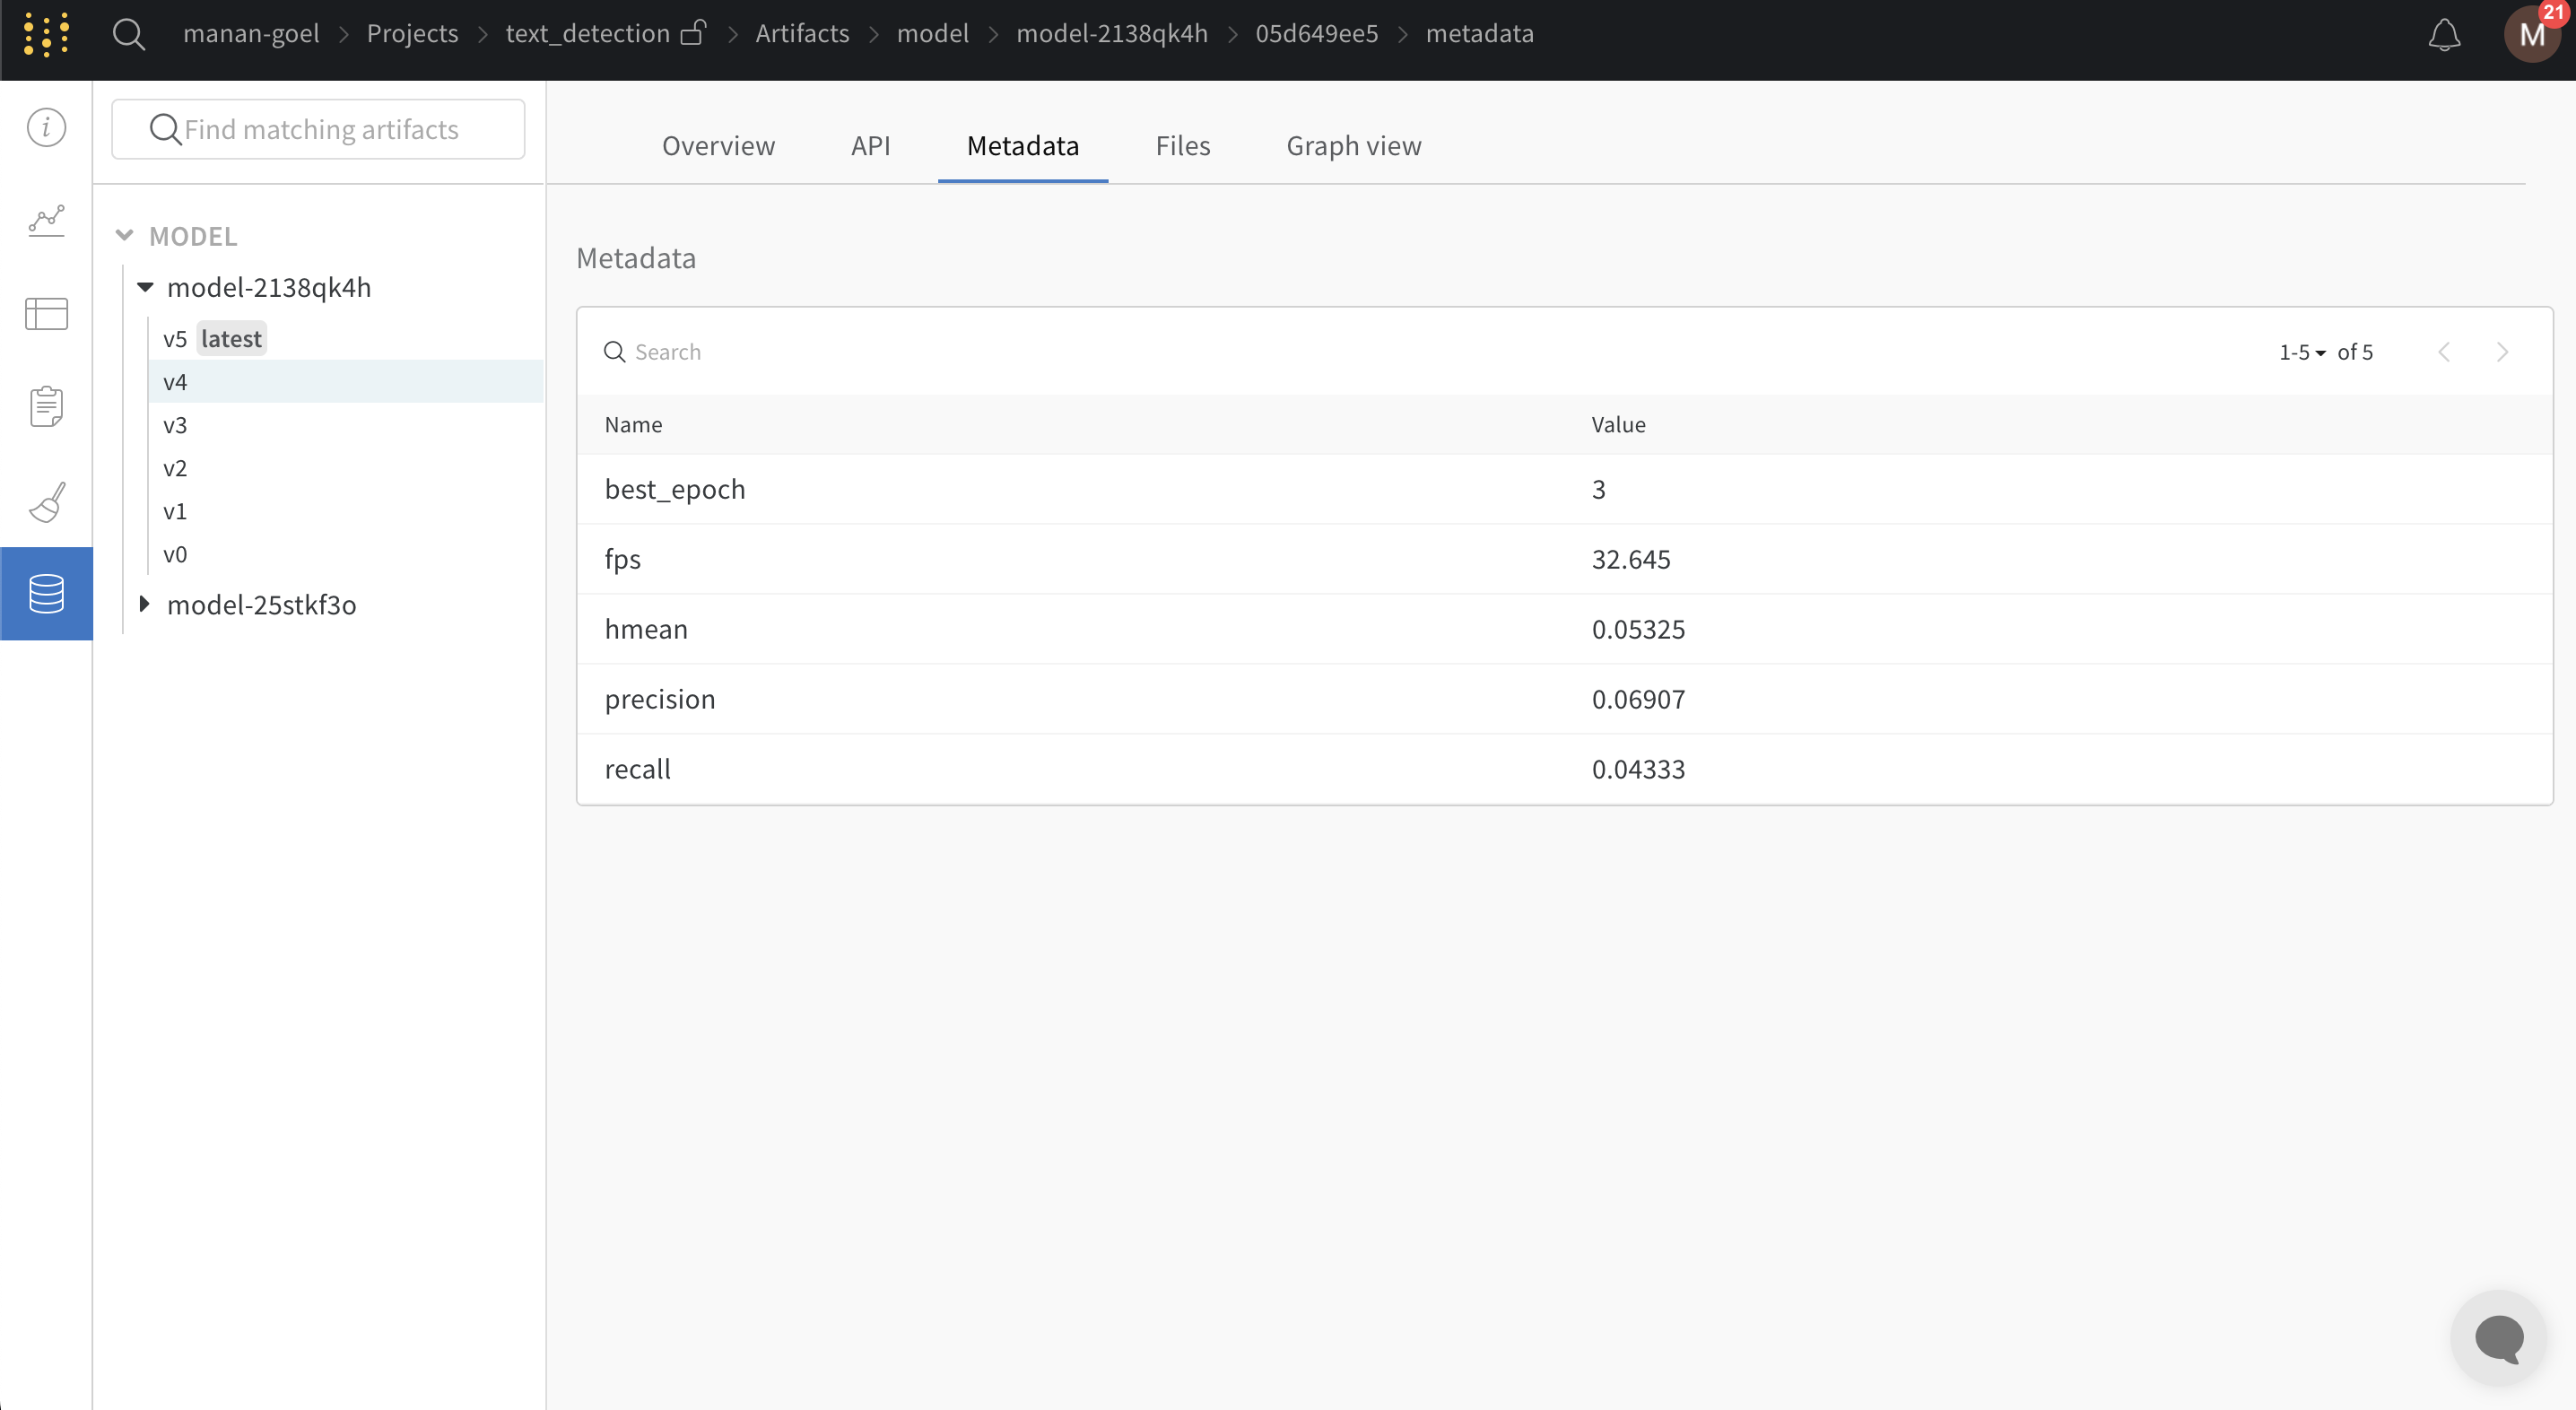

## Evaluation and Testing 🤔

### Downloading the best model from W&B 💿

To download the model with the best accuracy from W&B for evaluation you can use the following snippet

In [ ]:
import wandb
artifact = wandb.Api().artifact('manan-goel/text_detection/model-2138qk4h:best', type='model')
artifact_dir = artifact.download()

In [ ]:
artifact_dir

### Running the Evaluation Script

We will now use the checkpoint downloaded in the previous step to run the evaluation script

In [ ]:
!python3 tools/eval.py -c configs/det/det_mv3_db.yml  -o Global.checkpoints="./artifacts/model-2138qk4h:v9/model_ckpt" PostProcess.box_thresh=0.6 PostProcess.unclip_ratio=1.5

### Testing on Images 🧪

To test the model training we run the detection script from PaddleOCR on some test images.

In [ ]:
!python3 tools/infer_det.py -c configs/det/det_mv3_db.yml -o Global.infer_img="./doc/imgs_en/" Global.pretrained_model="./artifacts/model-2138qk4h:v9/model_ckpt"

### Bonus: Logging annotated images to your W&B dashboard 🔥

In [ ]:
wandb.init(project="text_detection")
wandb.use_artifact('manan-goel/text_detection/model-2138qk4h:best')

In [ ]:
table = wandb.Table(columns=["Input Image", "Annotated Image"])

In [ ]:
import glob
inp_imgs = sorted(glob.glob("./doc/imgs_en/*.jpg"), key=lambda x: x.split("/")[-1])
out_imgs = sorted(glob.glob("./output/det_db/det_results/*.jpg"), key=lambda x: x.split("/")[-1])

In [ ]:
for inp in inp_imgs:
    for out in out_imgs:
        if out.split("/")[-1] != inp.split("/")[-1]:
            continue
        table.add_data(
            wandb.Image(inp),
            wandb.Image(out)
        )

In [ ]:
wandb.log({
    "Predictions": table
})

In [ ]:
wandb.finish()

This gives a really cool visualization and debugging tool!

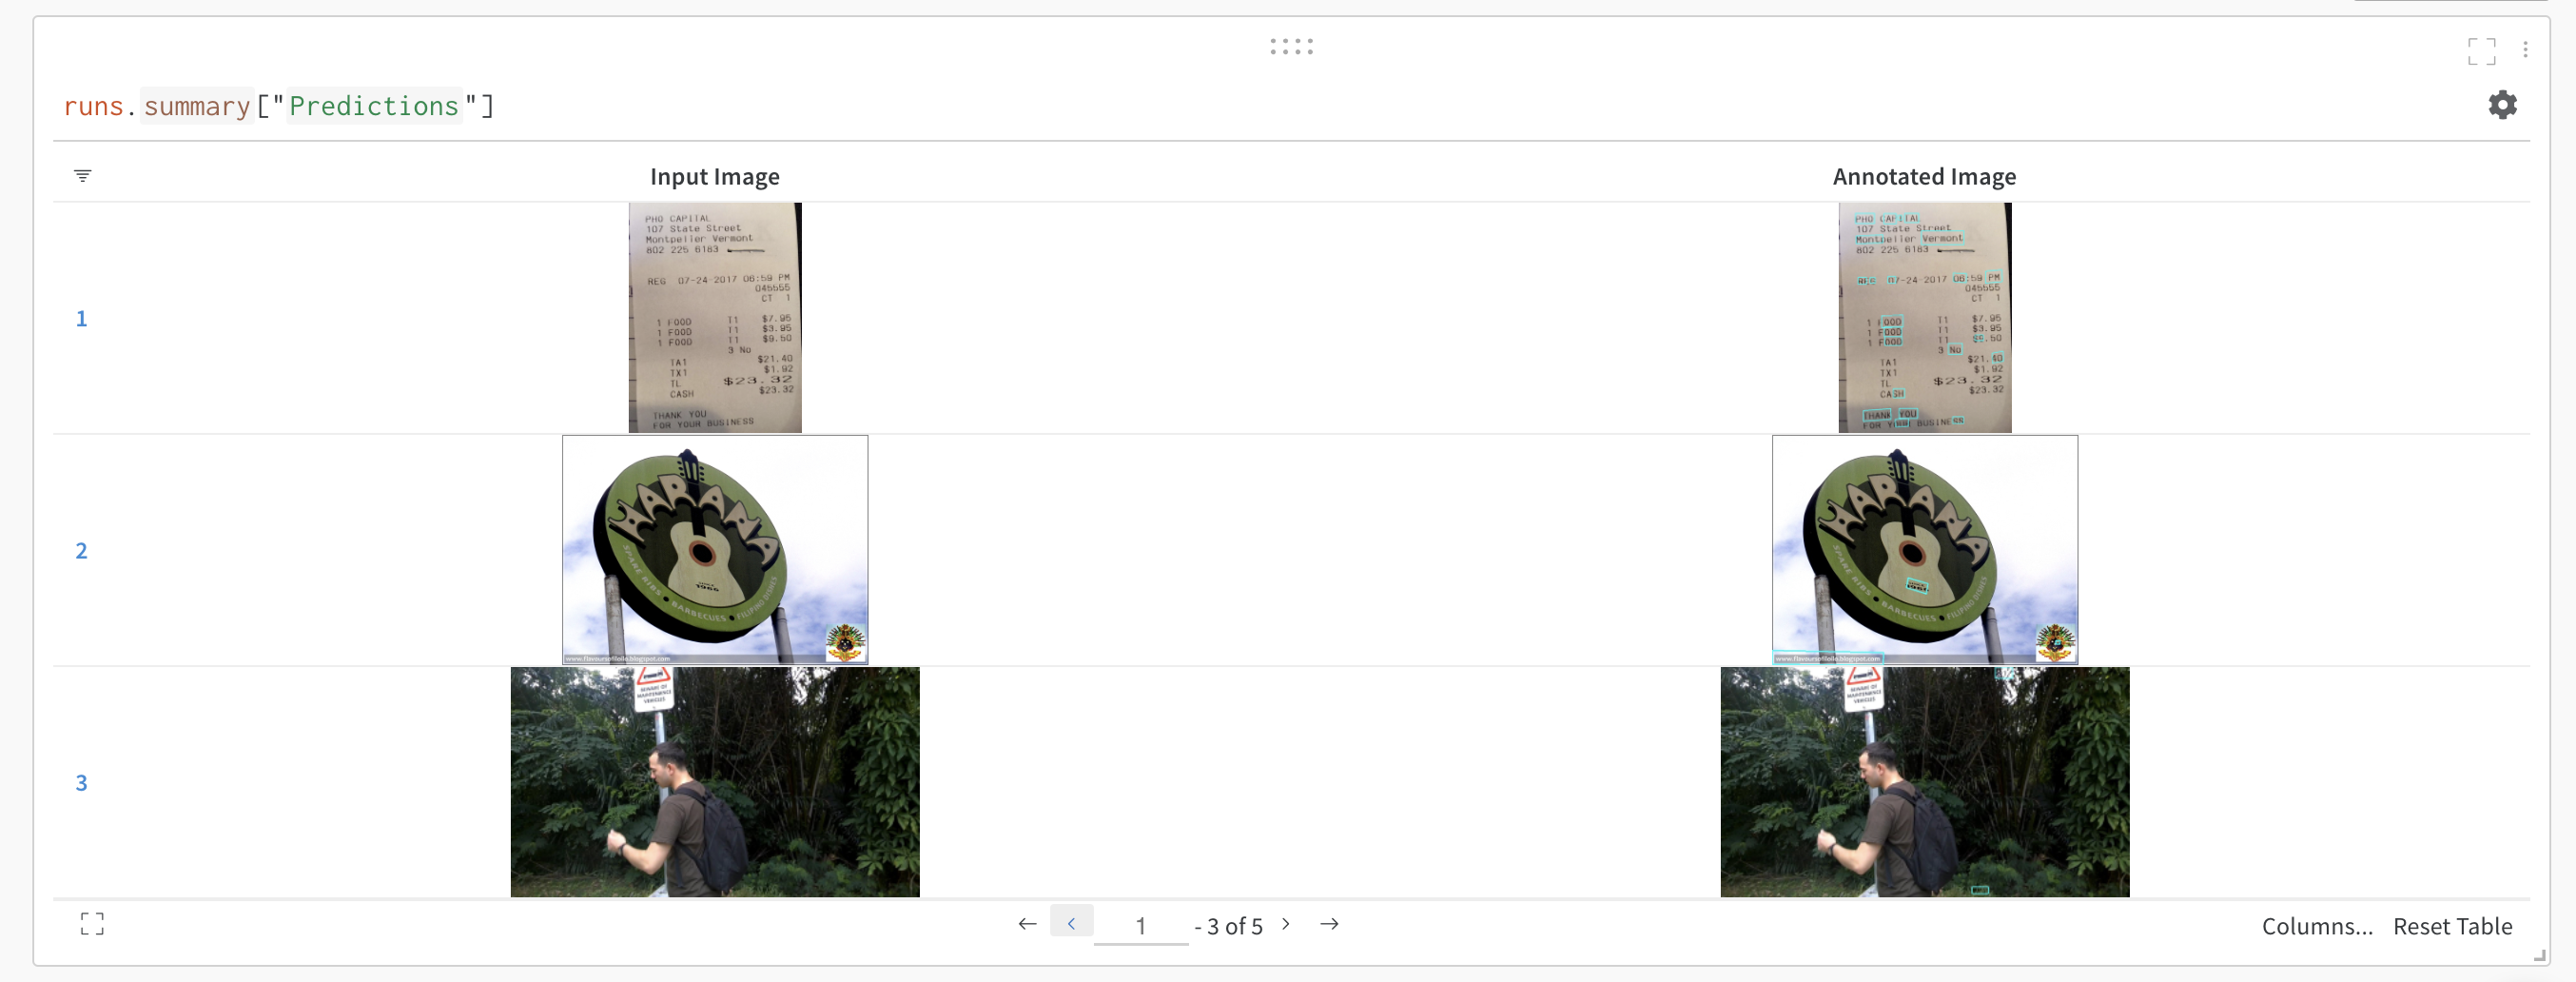

## Resources📕

*  [W&B and PaddleOCR Documentation](https://docs.wandb.ai/guides/integrations/other/paddleocr) contains a few tips for taking most advantage of W&B.
*  More PaddleOCR documentation is available [here](https://github.com/PaddlePaddle/PaddleOCR)


## Questions about W&B❓

If you have any questions about using W&B to track your model performance and predictions, please contact support@wandb.com